In [ ]:
pip install scikit-optimize


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.9 MB/s eta 0:00:00


In [ ]:
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from sklearn.model_selection import train_test_split
from collections import defaultdict

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1K2zmMuv0mj-vTdVmL7skUD_uFND0gg0U'

try:
    # Read the CSV file directly into a DataFrame
    adult_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)


adult_dataset

Decision tree

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import roc_curve, auc

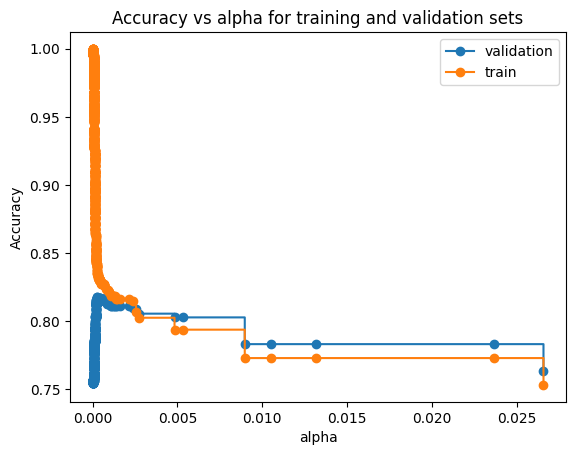

Best ccp_alpha based on validation set: 0.00027414365761517295


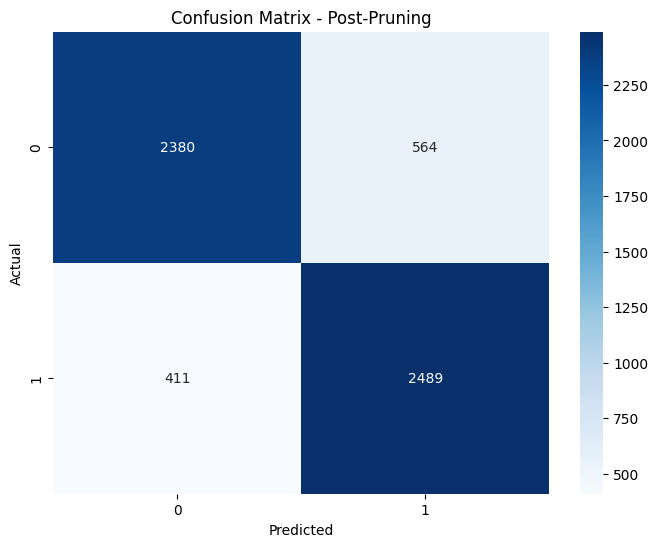

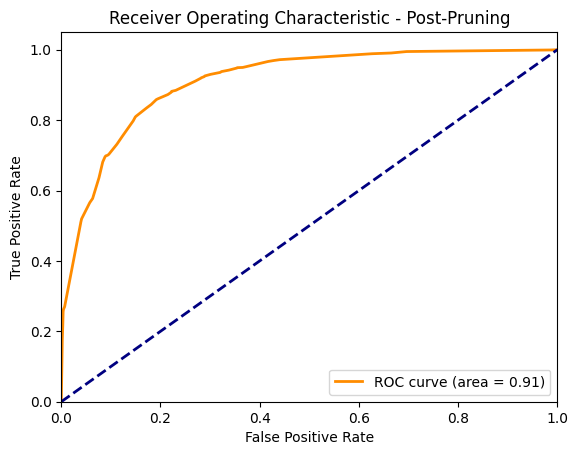

Post-Pruned Model Results:
Model: Decision Tree Post-Pruned
Cross-Validation Accuracies: [0.81558935 0.81064639 0.81780145 0.81437809 0.8212248 ]
Mean Cross-Validation Accuracy: 0.8159280155388784
Test Accuracy: 0.8331622176591376
Confusion Matrix: [[2380  564]
 [ 411 2489]]
Classification Report:               precision    recall  f1-score   support

           0       0.85      0.81      0.83      2944
           1       0.82      0.86      0.84      2900

    accuracy                           0.83      5844
   macro avg       0.83      0.83      0.83      5844
weighted avg       0.83      0.83      0.83      5844

ROC AUC: 0.908921769583958
ROC Curve: [ROC curve data]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Scale the 'fnlwgt' column
scaler = StandardScaler()
adult_dataset['fnlwgt'] = scaler.fit_transform(adult_dataset[['fnlwgt']])

X = adult_dataset.drop(['income'], axis=1)
y = adult_dataset['income']

# Split the dataset into training (75%), validation (25% of train), and testing sets (25%)
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=0)

### Post-Pruning (Reduced Error Pruning) ###
# Grow the full tree
full_tree = DecisionTreeClassifier(random_state=42)
full_tree.fit(X_train, y_train)

# Perform cost complexity pruning to simulate post-pruning
path = full_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Filter out invalid ccp_alpha values
ccp_alphas = ccp_alphas[ccp_alphas >= 0]

# Train trees with different values of ccp_alpha
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

val_scores = [accuracy_score(y_val, clf.predict(X_val)) for clf in clfs]
train_scores = [accuracy_score(y_train, clf.predict(X_train)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy vs alpha for training and validation sets")
ax.plot(ccp_alphas, val_scores, marker='o', label="validation", drawstyle="steps-post")
ax.plot(ccp_alphas, train_scores, marker='o', label="train", drawstyle="steps-post")
ax.legend()
plt.show()

# Selecting the best alpha based on validation set performance
best_index = np.argmax(val_scores)
best_alpha = ccp_alphas[best_index]
best_pruned_tree = clfs[best_index]

print(f"Best ccp_alpha based on validation set: {best_alpha}")

# Initialize and train the pruned tree with the best alpha value
clf_pruned = DecisionTreeClassifier(random_state=0, ccp_alpha=best_alpha).fit(X_train, y_train)
y_test_pred_post_pruned = clf_pruned.predict(X_test)
y_test_proba_post_pruned = clf_pruned.predict_proba(X_test)[:, 1]

# Perform cross-validation
cv = StratifiedKFold(n_splits=5)
cv_accuracies = cross_val_score(clf_pruned, X_train, y_train, cv=cv, scoring='accuracy')

# Evaluate Post-Pruned Model
accuracy_post_pruned = accuracy_score(y_test, y_test_pred_post_pruned)
conf_matrix_post_pruned = confusion_matrix(y_test, y_test_pred_post_pruned)
class_report_post_pruned = classification_report(y_test, y_test_pred_post_pruned)

# Plot Confusion Matrix for Post-Pruned Model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_post_pruned, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Post-Pruning')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot ROC Curve for Post-Pruned Model
fpr_post, tpr_post, _ = roc_curve(y_test, y_test_proba_post_pruned)
roc_auc_post = auc(fpr_post, tpr_post)

plt.figure()
plt.plot(fpr_post, tpr_post, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_post:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Post-Pruning')
plt.legend(loc="lower right")
plt.show()

# Save the evaluation metrics and results in a dictionary
adult_results_post_pruned = {
    'Model': 'Decision Tree Post-Pruned',
    'Cross-Validation Accuracies': cv_accuracies,
    'Mean Cross-Validation Accuracy': np.mean(cv_accuracies),
    'Test Accuracy': accuracy_post_pruned,
    'Confusion Matrix': conf_matrix_post_pruned,
    'Classification Report': class_report_post_pruned,
    'ROC AUC': roc_auc_post,
    'ROC Curve': {
        'FPR': fpr_post,
        'TPR': tpr_post,
        'Thresholds': _
    }
}

# Print results for inspection
print("Post-Pruned Model Results:")
for key, value in adult_results_post_pruned.items():
    if key != 'ROC Curve':
        print(f"{key}: {value}")
    else:
        print(f"{key}: [ROC curve data]")

XGboost

Cross-validation accuracies: [0.83823529 0.83743316 0.83609626 0.84010695 0.83952929]
Mean cross-validation accuracy: 0.84
Accuracy on Test Set: 0.85
Confusion Matrix:
[[1946  396]
 [ 307 2026]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      2342
           1       0.84      0.87      0.85      2333

    accuracy                           0.85      4675
   macro avg       0.85      0.85      0.85      4675
weighted avg       0.85      0.85      0.85      4675



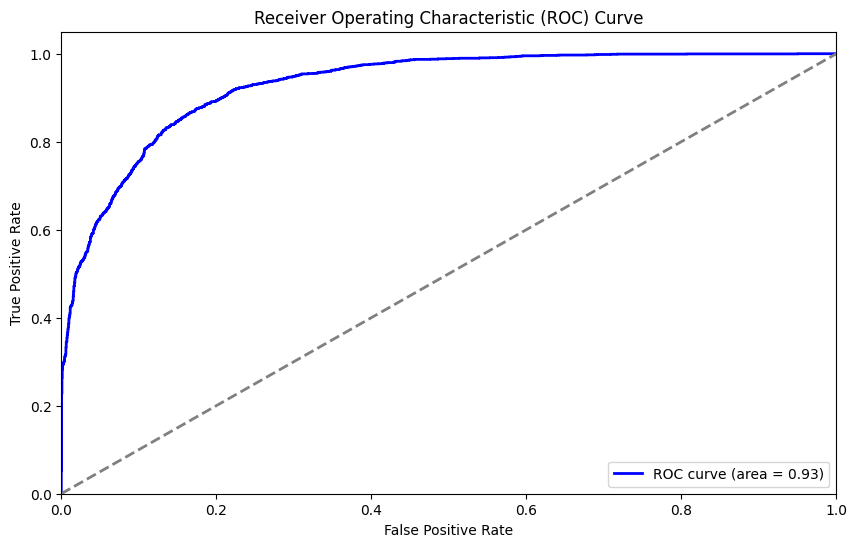

Model evaluation results:
Model: XGBoost Classifier
Cross-Validation Accuracies: [0.83823529 0.83743316 0.83609626 0.84010695 0.83952929]
Mean Cross-Validation Accuracy: 0.8382801887318665
Test Accuracy: 0.8496256684491978
Confusion Matrix: [[1946  396]
 [ 307 2026]]
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.83      0.85      2342
           1       0.84      0.87      0.85      2333

    accuracy                           0.85      4675
   macro avg       0.85      0.85      0.85      4675
weighted avg       0.85      0.85      0.85      4675

ROC AUC: 0.9292454125140971
ROC Curve: [ROC curve data]


In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

le = LabelEncoder()
adult_dataset['income'] = le.fit_transform(adult_dataset['income'])

# Prepare features and target
X = adult_dataset.drop('income', axis=1)
y = adult_dataset['income']

# Handle categorical variables if any (example using get_dummies)
X = pd.get_dummies(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the hyperparameters directly
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'colsample_bytree': 0.9907774996048742,
    'learning_rate': 0.161975478108026,
    'max_depth': 3,
    'n_estimators': 300,
    'subsample': 0.8822164881657227
}

# Initialize the XGBoost classifier with the specified hyperparameters
xgb_classifier = xgb.XGBClassifier(**params)

# Perform cross-validation and calculate the accuracy for each fold
cv = StratifiedKFold(n_splits=5)
cv_accuracies = cross_val_score(xgb_classifier, X_train, y_train, cv=cv, scoring='accuracy')

# Fit the model
xgb_classifier.fit(X_train, y_train)

# Use the fitted model to make predictions
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ROC Curve
y_prob = xgb_classifier.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Print cross-validation results
print(f'Cross-validation accuracies: {cv_accuracies}')
print(f'Mean cross-validation accuracy: {np.mean(cv_accuracies):.2f}')

# Print the accuracy
print(f"Accuracy on Test Set: {accuracy:.2f}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("Classification Report:")
print(class_report)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the evaluation metrics and results in a dictionary
adult_results_xgb = {
    'Model': 'XGBoost Classifier',
    'Cross-Validation Accuracies': cv_accuracies,
    'Mean Cross-Validation Accuracy': np.mean(cv_accuracies),
    'Test Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Classification Report': class_report,
    'ROC AUC': roc_auc,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }
}

# Print results for inspection
print("Model evaluation results:")
for key, value in adult_results_xgb.items():
    if key != 'ROC Curve':
        print(f"{key}: {value}")
    else:
        print(f"{key}: [ROC curve data]")

  MLP

Cross-validation accuracies: [0.82941176 0.8144385  0.79973262 0.82887701 0.81064456]
Mean cross-validation accuracy: 0.82
F1 Score: 0.8190944478590452


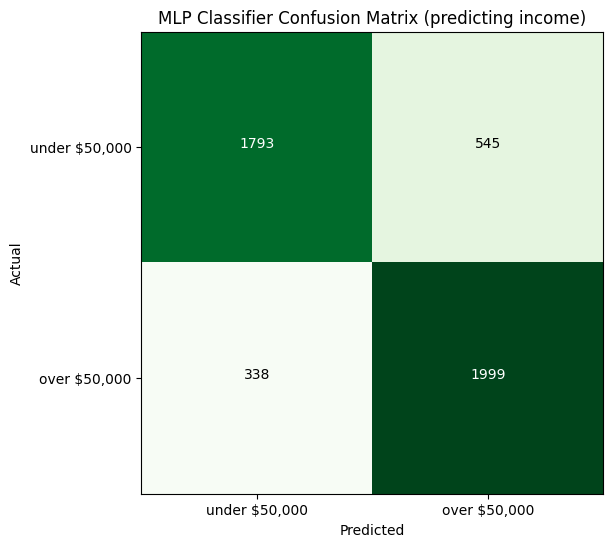

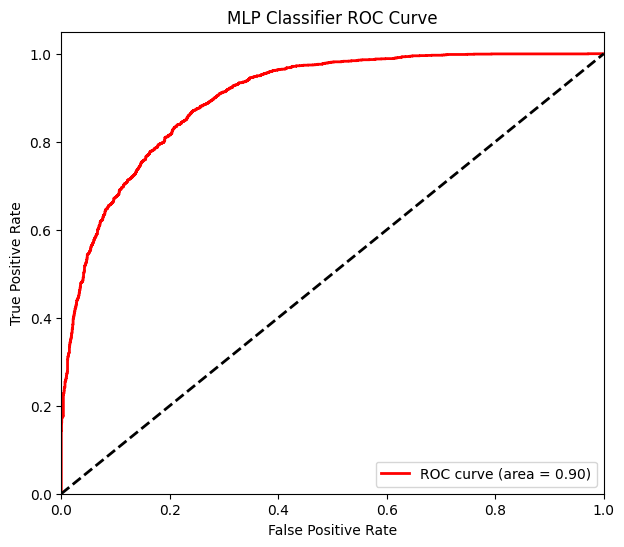

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.77      0.80      2338
           1       0.79      0.86      0.82      2337

    accuracy                           0.81      4675
   macro avg       0.81      0.81      0.81      4675
weighted avg       0.81      0.81      0.81      4675

Accuracy: 0.8111229946524064
Model evaluation results:
Model: MLP Classifier
Cross-Validation Accuracies: [0.82941176 0.8144385  0.79973262 0.82887701 0.81064456]
Mean Cross-Validation Accuracy: 0.8166208900832818
Test Accuracy: 0.8111229946524064
F1 Score: 0.8190944478590452
ROC AUC: 0.9015859716473893
ROC Curve: [ROC curve data]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

X_adult = adult_dataset.drop('income', axis=1)
y_adult = adult_dataset['income']

# Standardize the 'fnlwgt' column
scaler = StandardScaler()
X_adult[['fnlwgt']] = scaler.fit_transform(X_adult[['fnlwgt']])

# Split the data
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_adult, y_adult, test_size=0.2, random_state=42, stratify=y_adult)

# Define the hyperparameters directly
params_C = {
    'hidden_layer_sizes': (50, 100, 50),
    'activation': 'relu',
    'alpha': 0.0001,
    'learning_rate': 'constant',
    'solver': 'adam',
    'max_iter': 1000
}

# Initialize the MLPClassifier with the specified hyperparameters
mlp_C = MLPClassifier(**params_C)

# Perform cross-validation and calculate the accuracy for each fold
cv = StratifiedKFold(n_splits=5)
cv_accuracies = cross_val_score(mlp_C, X_train_C, y_train_C, cv=cv, scoring='accuracy')

# Fit the model on the full training data
mlp_C.fit(X_train_C, y_train_C)

# Use the fitted model to make predictions
y_pred_C = mlp_C.predict(X_test_C)

# Evaluate
f1_C = f1_score(y_test_C, y_pred_C)
conf_matrix_C = confusion_matrix(y_test_C, y_pred_C)

# Print cross-validation results
print(f'Cross-validation accuracies: {cv_accuracies}')
print(f'Mean cross-validation accuracy: {np.mean(cv_accuracies):.2f}')

# Print the F1 score
print("F1 Score:", f1_C)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_C, cmap=plt.cm.Greens)
plt.title('MLP Classifier Confusion Matrix (predicting income)')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['under $50,000', 'over $50,000'])
plt.yticks(tick_marks, ['under $50,000', 'over $50,000'])

thresh = conf_matrix_C.max() / 2.
for i, j in np.ndindex(conf_matrix_C.shape):
    plt.text(j, i, format(conf_matrix_C[i, j], 'd'),
             horizontalalignment="center",
             color="white" if conf_matrix_C[i, j] > thresh else "black")

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Plot the ROC curve
y_prob_C = mlp_C.predict_proba(X_test_C)[:, 1]
fpr, tpr, _ = roc_curve(y_test_C, y_prob_C)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('MLP Classifier ROC Curve')
plt.legend(loc='lower right')
plt.show()

# Print classification report and accuracy
report_C = classification_report(y_test_C, y_pred_C)
accuracy_C = accuracy_score(y_test_C, y_pred_C)

print("Classification Report:\n", report_C)
print("Accuracy:", accuracy_C)

# Save the evaluation metrics and results in a dictionary
adult_results_mlp = {
    'Model': 'MLP Classifier',
    'Cross-Validation Accuracies': cv_accuracies,
    'Mean Cross-Validation Accuracy': np.mean(cv_accuracies),
    'Test Accuracy': accuracy_C,
    'F1 Score': f1_C,
    'ROC AUC': roc_auc,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': _
    }
}

# Print results for inspection
print("Model evaluation results:")
for key, value in adult_results_mlp.items():
    if key != 'ROC Curve':
        print(f"{key}: {value}")
    else:
        print(f"{key}: [ROC curve data]")

KNN

Cross-validation accuracies: [0.80909091 0.78983957 0.79411765 0.80160428 0.80235357]
Mean cross-validation accuracy: 0.80
Accuracy: 0.7970053475935829
Confusion Matrix:
[[1794  544]
 [ 405 1932]]
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.79      2338
           1       0.78      0.83      0.80      2337

    accuracy                           0.80      4675
   macro avg       0.80      0.80      0.80      4675
weighted avg       0.80      0.80      0.80      4675



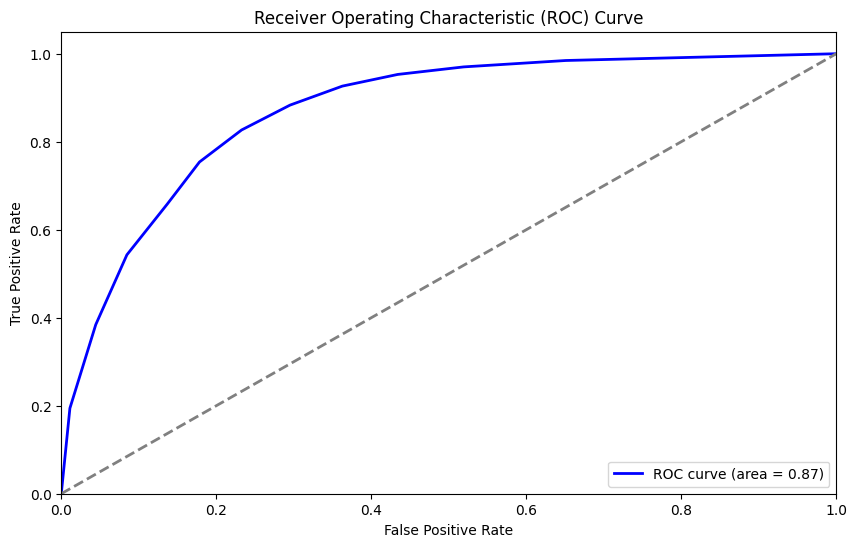

Model evaluation results:
Model: KNeighborsClassifier
Cross-Validation Accuracies: [0.80909091 0.78983957 0.79411765 0.80160428 0.80235357]
Mean Cross-Validation Accuracy: 0.7994011953781002
Test Accuracy: 0.7970053475935829
Confusion Matrix: [[1794  544]
 [ 405 1932]]
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.77      0.79      2338
           1       0.78      0.83      0.80      2337

    accuracy                           0.80      4675
   macro avg       0.80      0.80      0.80      4675
weighted avg       0.80      0.80      0.80      4675

ROC AUC: 0.8715183789765051
ROC Curve: [ROC curve data]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

X = adult_dataset.drop('income', axis=1)
y = adult_dataset['income']

# Normalize the features if not already normalized
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Define the hyperparameters directly
params = {
    'n_neighbors': 11,
    'weights': 'uniform',
    'metric': 'manhattan'
}

# Initialize the KNeighborsClassifier with the specified hyperparameters
knn = KNeighborsClassifier(**params)

# Perform cross-validation and calculate the accuracy for each fold
cv = StratifiedKFold(n_splits=5)
cv_accuracies = cross_val_score(knn, X_train, y_train, cv=cv, scoring='accuracy')

# Fit the model on the full training data
knn.fit(X_train, y_train)

# Use the fitted model to make predictions
y_pred = knn.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ROC Curve
y_prob = knn.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

# Print cross-validation results
print(f'Cross-validation accuracies: {cv_accuracies}')
print(f'Mean cross-validation accuracy: {np.mean(cv_accuracies):.2f}')

# Print the accuracy
print(f"Accuracy: {accuracy}")

# Print confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Print classification report
print("Classification Report:")
print(class_report)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the evaluation metrics and results in a dictionary
adult_results_knn = {
    'Model': 'KNeighborsClassifier',
    'Cross-Validation Accuracies': cv_accuracies,
    'Mean Cross-Validation Accuracy': np.mean(cv_accuracies),
    'Test Accuracy': accuracy,
    'Confusion Matrix': conf_matrix,
    'Classification Report': class_report,
    'ROC AUC': roc_auc,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }
}

# Print results for inspection
print("Model evaluation results:")
for key, value in adult_results_knn.items():
    if key != 'ROC Curve':
        print(f"{key}: {value}")
    else:
        print(f"{key}: [ROC curve data]")

SVM

Best Parameters: {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
Cross-Validation Accuracies: [0.80668449 0.82032086 0.81176471 0.8131016  0.82374967]
Mean Cross-Validation Accuracy: 0.8151242646880045
Test Accuracy: 0.8224598930481284
Confusion Matrix:
[[1850  492]
 [ 338 1995]]
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2342
           1       0.80      0.86      0.83      2333

    accuracy                           0.82      4675
   macro avg       0.82      0.82      0.82      4675
weighted avg       0.82      0.82      0.82      4675



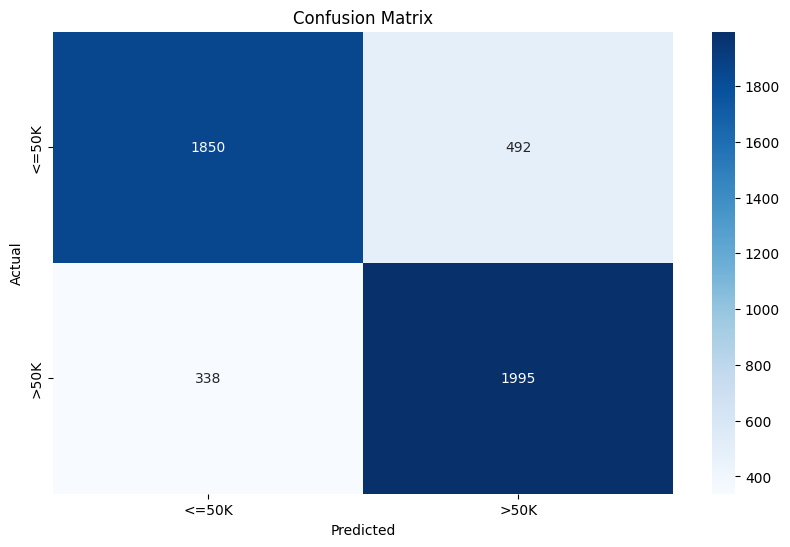

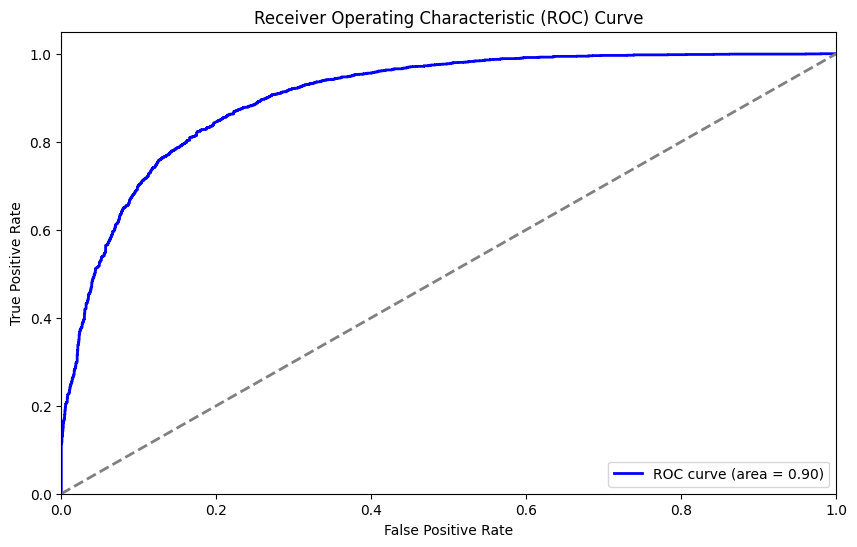

In [89]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define features and target
X = adult_dataset.drop('income', axis=1)
y = adult_dataset['income']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the best parameters
best_params = {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

# Initialize the SVM with the best parameters
best_svm = SVC(C=best_params['C'], gamma=best_params['gamma'], kernel=best_params['kernel'], probability=True)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=cv, scoring='accuracy')

# Train the model using the training data
best_svm.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_svm.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# ROC Curve
y_prob = best_svm.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Best Parameters: {best_params}")
print(f"Cross-Validation Accuracies: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_scores)}")
print(f"Test Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

# Plot Confusion Matrix
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Save the evaluation metrics and results in a dictionary
adult_results_svm = {
    'Model': 'SVM Classifier',
    'Cross-Validation Accuracies': cv_scores,
    'Mean Cross-Validation Accuracy': np.mean(cv_scores),
    'Test Accuracy': accuracy,
    'ROC AUC': roc_auc,
    'Confusion Matrix': conf_matrix,
    'Classification Report': class_report,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }
}


In [97]:
adult_results_svm = {
    'Model': 'SVM Classifier',
    'Cross-Validation Accuracies': cv_scores,
    'Mean Cross-Validation Accuracy': np.mean(cv_scores),
    'Test Accuracy': accuracy,
    'ROC AUC': roc_auc,
    'Confusion Matrix': conf_matrix,
    'Classification Report': class_report,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }
}

DQL

Episode 1/10 completed.
Episode 2/10 completed.
Episode 3/10 completed.
Episode 4/10 completed.
Episode 5/10 completed.
Episode 6/10 completed.
Episode 7/10 completed.
Episode 8/10 completed.
Episode 9/10 completed.
Episode 10/10 completed.
Evaluation Accuracy: 78.27%
Confusion Matrix:
[[1860  482]
 [ 534 1799]]


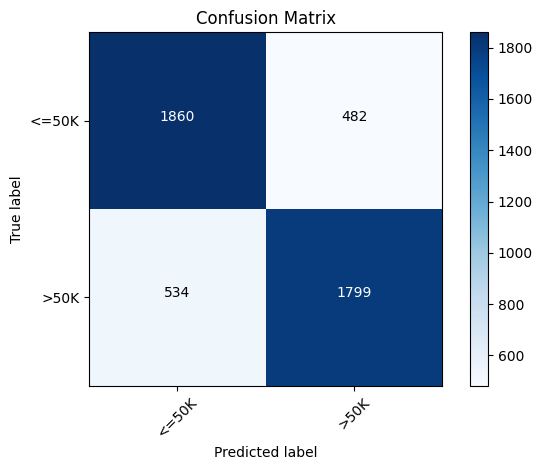


Classification Report:
              precision    recall  f1-score   support

       <=50K       0.78      0.79      0.79      2342
        >50K       0.79      0.77      0.78      2333

    accuracy                           0.78      4675
   macro avg       0.78      0.78      0.78      4675
weighted avg       0.78      0.78      0.78      4675



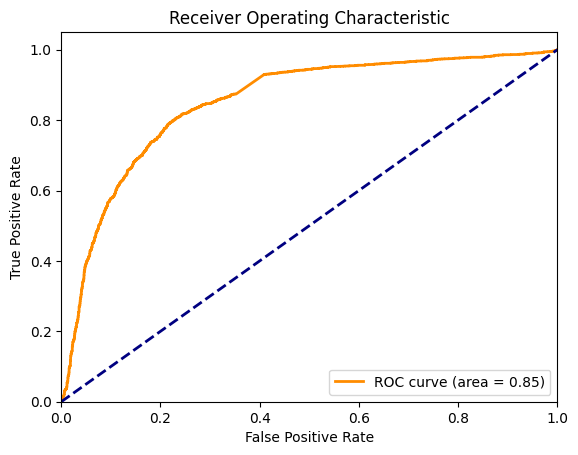

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from collections import deque
import random
import itertools
import matplotlib.pyplot as plt


# Define features and target
X = adult_dataset.drop(columns=['income'])
y = adult_dataset['income']

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.int64)
y_test = torch.tensor(y_test.values, dtype=torch.int64)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = DQN(state_dim, action_dim)
        self.target_model = DQN(state_dim, action_dim)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            q_values = self.model(state)
        return torch.argmax(q_values).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*minibatch)
        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)

        q_values = self.model(states).gather(1, actions.view(-1, 1)).squeeze()
        next_q_values = self.target_model(next_states).max(1)[0]
        target_q_values = rewards + (self.gamma * next_q_values * (1 - dones))

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

def train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq):
    for episode in range(n_episodes):
        for idx in range(len(X_train)):
            state = X_train[idx].numpy()
            action = agent.act(state)
            reward = 1 if action == y_train[idx].item() else -1
            next_state = state
            done = True
            agent.remember(state, action, reward, next_state, done)
            agent.replay()

        if episode % target_update_freq == 0:
            agent.update_target_network()
        print(f"Episode {episode + 1}/{n_episodes} completed.")

def evaluate_dqn_agent(agent, X_test, y_test):
    y_pred = []
    y_pred_prob = []
    for idx in range(len(X_test)):
        state = X_test[idx].numpy()
        state_tensor = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            q_values = agent.model(state_tensor)
        y_pred_prob.append(torch.softmax(q_values, dim=0)[1].item())
        y_pred.append(torch.argmax(q_values).item())
    accuracy = np.mean(np.array(y_pred) == y_test.numpy())
    print(f"Evaluation Accuracy: {accuracy * 100:.2f}%")
    return y_pred, y_pred_prob

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Hyperparameters
state_dim = X_train.shape[1]
action_dim = 2  # Binary classification (0 or 1)
learning_rate = 0.001
gamma = 0.99
epsilon = 1.0
epsilon_decay = 0.995
epsilon_min = 0.01
memory_size = 2000
batch_size = 64
n_episodes = 10
target_update_freq = 10

agent = DQNAgent(state_dim, action_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size)

# Train the agent
train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq)

# Evaluate the agent
y_pred, y_pred_prob = evaluate_dqn_agent(agent, X_test, y_test)

# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

plot_confusion_matrix(cm, classes=['<=50K', '>50K'], title='Confusion Matrix')
plt.show()

class_report = classification_report(y_test, y_pred, target_names=['<=50K', '>50K'])

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['<=50K', '>50K']))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = roc_auc_score(y_test, y_pred_prob)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Save results to a dictionary
results_dqn = {
    'Model': 'DQN Classifier',
    'Test Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc,
    'Confusion Matrix': cm,
    'Classification Report': class_report,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds.tolist()
    }
}

In [96]:
adultresults_dqn = {
    'Model': 'DQN Classifier',
    'Test Accuracy': accuracy_score(y_test, y_pred),
    'ROC AUC': roc_auc,
    'Confusion Matrix': cm,
    'Classification Report': class_report,
    'ROC Curve': {
        'FPR': fpr,
        'TPR': tpr,
        'Thresholds': thresholds
    }}

Adult dataset model performance comparison

In [109]:
adult_results_list = [adult_results_mlp, adult_results_knn, adult_results_xgb, adult_results_post_pruned, adultresults_dqn, adult_results_svm]

import matplotlib.pyplot as plt

def plot_roc_curves(results_list):
    plt.figure(figsize=(10, 8))

    for result in results_list:
        fpr = result['ROC Curve']['FPR']
        tpr = result['ROC Curve']['TPR']
        roc_auc = result['ROC AUC']
        model_name = result['Model']

        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

def plot_test_accuracies(results_list):
    model_names = []
    test_accuracies = []

    for result in results_list:
        model_names.append(result['Model'])
        test_accuracies.append(result['Test Accuracy'])

    x = np.arange(len(model_names))
    width = 0.35
    fig, ax = plt.subplots(figsize=(12, 6))
    rects = ax.bar(x, test_accuracies, width, label='Test Accuracy')

    # Add labels, title
    ax.set_xlabel('Models')
    ax.set_ylabel('Accuracy')
    ax.set_title('Test Accuracy for Adult dataset')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()

    fig.tight_layout()
    plt.show()


def plot_cv_accuracies(results_list):
    plt.figure(figsize=(12, 8))
    num_models = len(results_list)
    bar_width = 0.35
    index = np.arange(len(results_list[0]['Cross-Validation Accuracies']))

    for i, result in enumerate(results_list):
        cv_accuracies = result['Cross-Validation Accuracies']
        model_name = result['Model']

        plt.bar(index + i * bar_width, cv_accuracies, bar_width, label=f'{model_name}')

    plt.xlabel('Epochs')
    plt.ylabel('Cross-Validation Accuracy')
    plt.title('Cross-Validation Accuracy over Epochs')
    plt.xticks(index + bar_width * (num_models - 1) / 2, range(1, len(cv_accuracies) + 1))
    plt.legend(loc="lower right")
    plt.show()

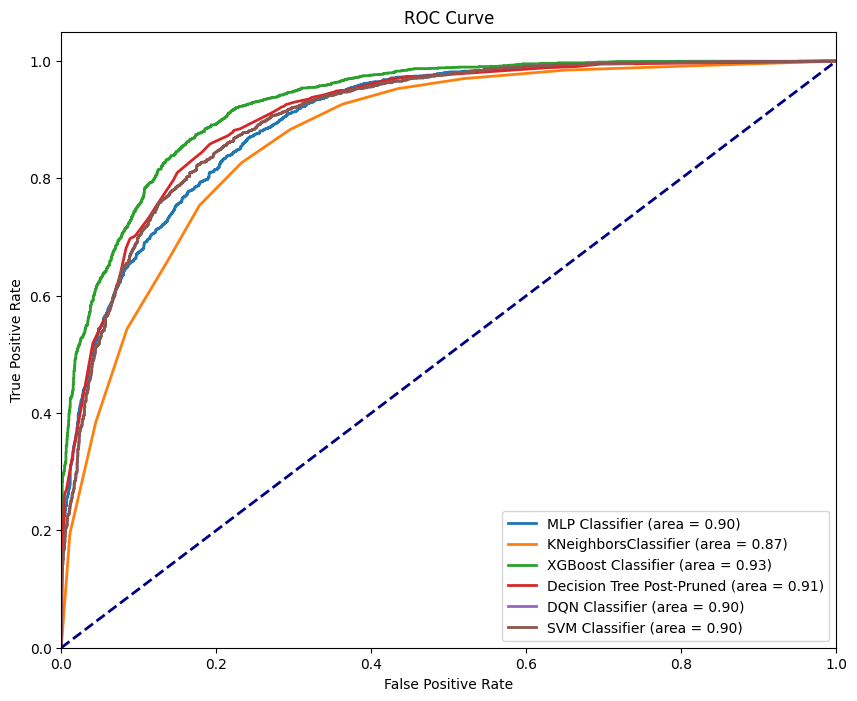

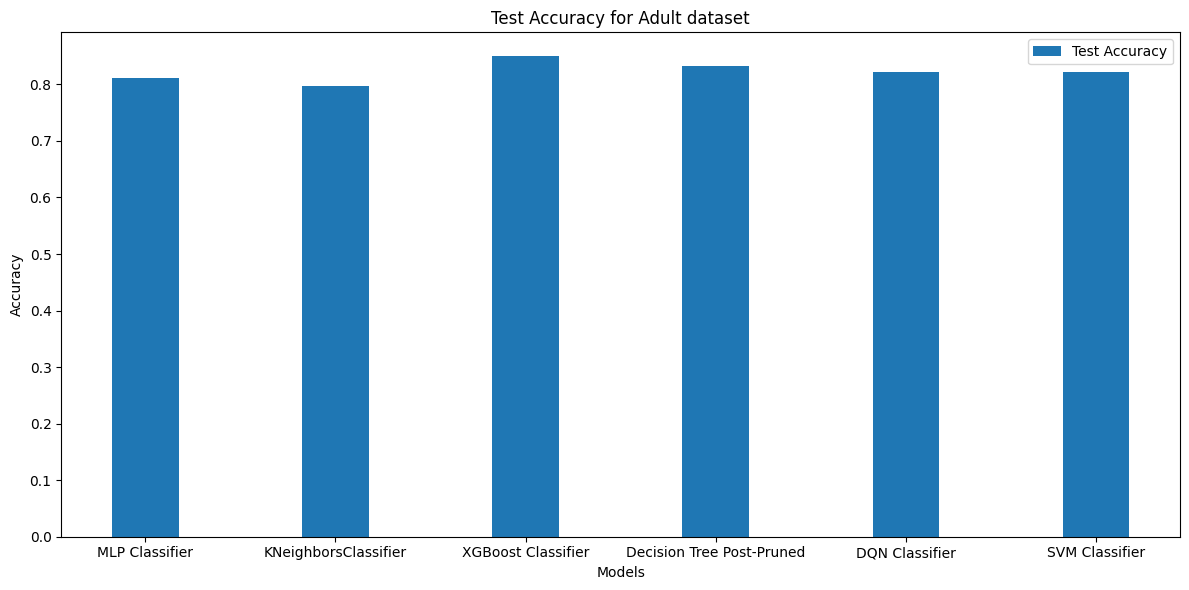

In [110]:



# Plot ROC Curves
plot_roc_curves(adult_results_list)

# Plot Accuracies
plot_test_accuracies(adult_results_list)

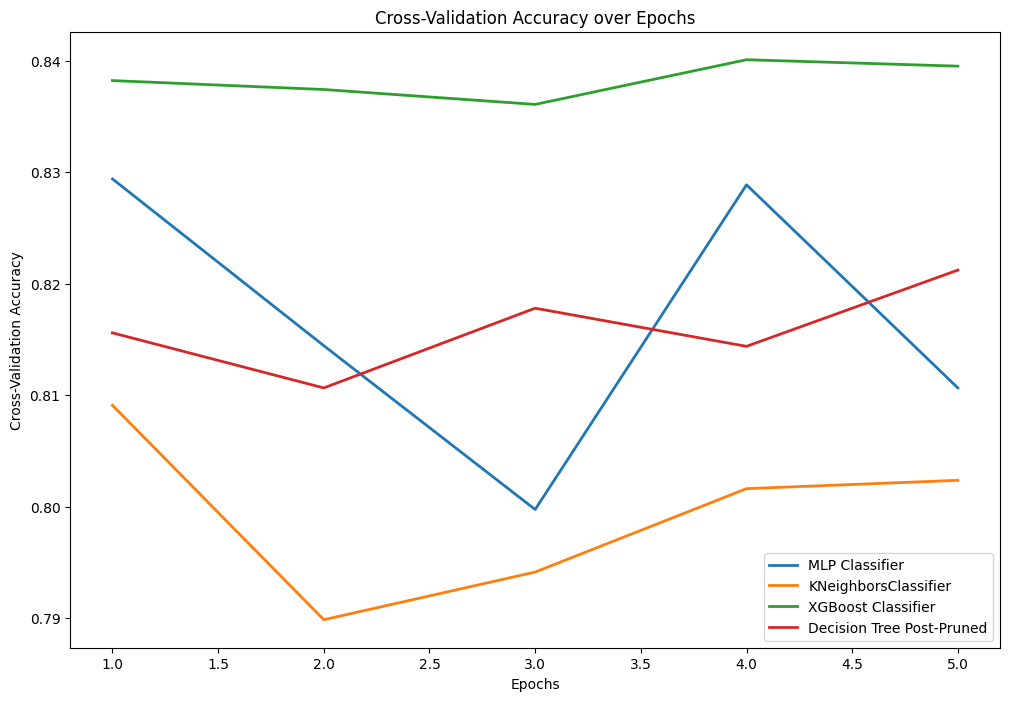

In [102]:
adult_results_list = [adult_results_mlp, adult_results_knn, adult_results_xgb, adult_results_post_pruned]


# Plot CV Accuracies over Epochs
plot_cv_accuracies(adult_results_list)

In [114]:
adult_results_list = [
    adult_results_mlp,
    adult_results_knn,
    adult_results_xgb,
    adult_results_post_pruned,
    adultresults_dqn,
    adult_results_svm
]

for result_dict in adult_results_list:
    for key, value in result_dict.items():
        print(f"{key}: {value}")
    print()

Model: MLP Classifier
Cross-Validation Accuracies: [0.82941176 0.8144385  0.79973262 0.82887701 0.81064456]
Mean Cross-Validation Accuracy: 0.8166208900832818
Test Accuracy: 0.8111229946524064
F1 Score: 0.8190944478590452
ROC AUC: 0.9015859716473893
ROC Curve: {'FPR': array([0.        , 0.        , 0.        , ..., 0.97177074, 0.97177074,
       1.        ]), 'TPR': array([0.        , 0.02524604, 0.14377407, ..., 0.9995721 , 1.        ,
       1.        ]), 'Thresholds': array([2.00000000e+00, 1.00000000e+00, 9.98692566e-01, ...,
       9.35734577e-05, 8.98722136e-05, 6.89700203e-08])}

Model: KNeighborsClassifier
Cross-Validation Accuracies: [0.80909091 0.78983957 0.79411765 0.80160428 0.80235357]
Mean Cross-Validation Accuracy: 0.7994011953781002
Test Accuracy: 0.7970053475935829
Confusion Matrix: [[1794  544]
 [ 405 1932]]
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.77      0.79      2338
           1       0.78      0

Rent dataset

In [ ]:
import pandas as pd

# Direct download URL for the Google Drive file
CSV_URL = 'https://drive.google.com/uc?export=download&id=1iyhG9KK2SpLS1BxP6axyTMZw7RMjWgwR'

try:
    # Read the CSV file directly into a DataFrame
    rent_apartments_dataset = pd.read_csv(CSV_URL)
except Exception as e:
    print("Error reading the CSV file:", e)

Decision trees

Mean Squared Error (MSE): 0.30118733518166924
R-squared (R²): 0.7040029618600568
Mean Absolute Error (MAE): 0.3836146930331151


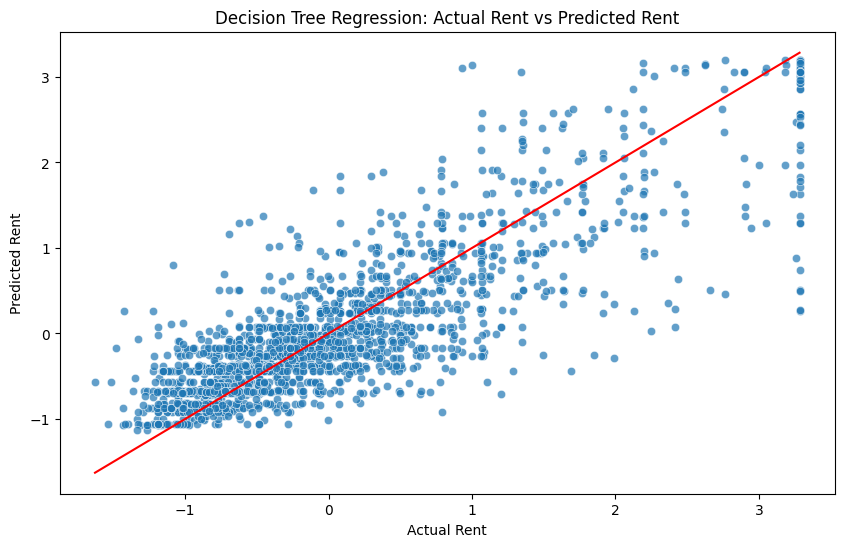

In [ ]:
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns

# Prepare features and target
X = rent_apartments_dataset.drop('price', axis=1)  # Features
y = rent_apartments_dataset['price']  # Target variable

# Scaling the features (if not already scaled)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the best parameters
best_params = {
    'max_depth': 10,
    'max_features': None,
    'max_leaf_nodes': None,
    'min_impurity_decrease': 0.0001,
    'min_samples_leaf': 6,
    'min_samples_split': 2,
}

# Create the Decision Tree Regressor with the best parameters
best_regressor = DecisionTreeRegressor(
    max_depth=best_params['max_depth'],
    max_features=best_params['max_features'],
    max_leaf_nodes=best_params['max_leaf_nodes'],
    min_impurity_decrease=best_params['min_impurity_decrease'],
    min_samples_leaf=best_params['min_samples_leaf'],
    min_samples_split=best_params['min_samples_split'],
    random_state=42
)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_regressor, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Train the model using the training data
best_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = best_regressor.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Save the evaluation metrics and results in a dictionary
results_tree = {
    'Model': 'Decision Tree Regressor',
    'Cross-Validation MSE': -cv_scores,
    'Mean Cross-Validation MSE': -np.mean(cv_scores),
    'Test MSE': mse,
    'R²': r2,
    'MAE': mae,
    'Predictions': y_pred
}

# Convert the results to a DataFrame
rent_results_df = pd.DataFrame([results_tree])

# Plotting Actual vs Predicted Rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("Decision Tree Regression: Actual Rent vs Predicted Rent")
plt.show()


xgboost

Mean Squared Error (MSE): 0.18875172552377598
R-squared (R²): 0.8145009926624514
Mean Absolute Error (MAE): 0.29887637550729473


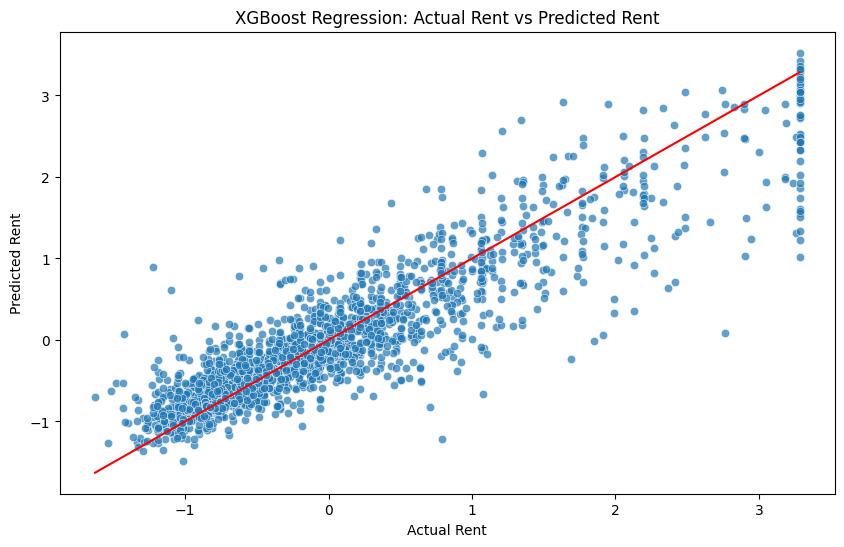

In [ ]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Prepare features and target
X = rent_apartments_dataset.drop('price', axis=1)
y = rent_apartments_dataset['price']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define the best parameters
best_params = {
    'colsample_bytree': 0.7,
    'learning_rate': 0.1,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 1.0
}

# Initialize the XGBoost regressor with the best parameters
xgb_regressor = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=best_params['colsample_bytree'],
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    random_state=42
)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(xgb_regressor, X_train, y_train, cv=cv, scoring='neg_mean_squared_error')

# Train the model using the training data
xgb_regressor.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xgb_regressor.predict(X_test)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R²): {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

# Save the evaluation metrics and results in a dictionary
results_xgb = {
    'Model': 'XGBoost Regressor',
    'Cross-Validation MSE': -cv_scores,
    'Mean Cross-Validation MSE': -np.mean(cv_scores),
    'Test MSE': mse,
    'R²': r2,
    'MAE': mae,
    'Predictions': y_pred
}

# Convert the results to a DataFrame
rent_results_df = pd.DataFrame([results_xgb])

# Plotting Actual vs Predicted Rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("XGBoost Regression: Actual Rent vs Predicted Rent")
plt.show()


MLP

MLP Regression Mean Squared Error (MSE): 0.29462590881751327
MLP Regression R-squared (R²): 0.7104513165645866
MLP Regression Mean Absolute Error (MAE): 0.3813425598152561


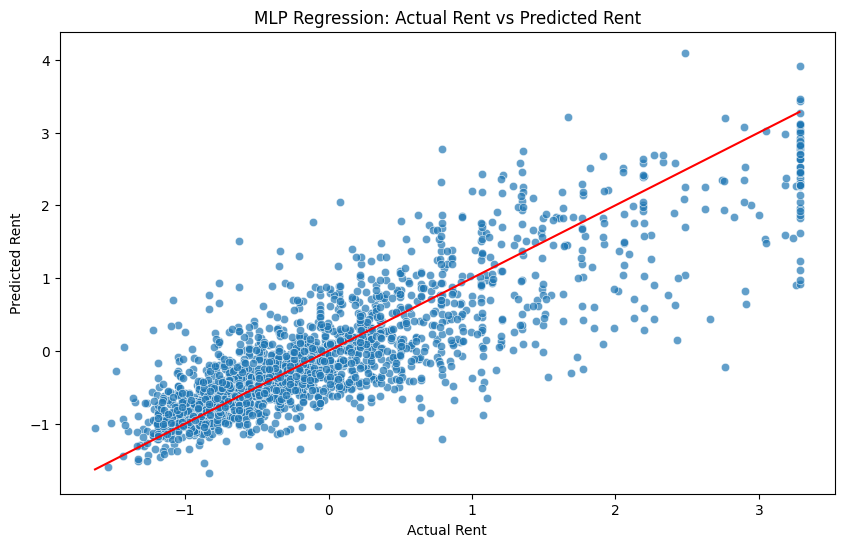

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# Prepare features and target
X_rent = rent_apartments_dataset.drop('price', axis=1)
y_rent = rent_apartments_dataset['price']

# Standardize specific features
scaler = StandardScaler()
X_rent[['latitude', 'longitude', 'time']] = scaler.fit_transform(X_rent[['latitude', 'longitude', 'time']])

# Split the data into train and test sets
X_train_R, X_test_R, y_train_R, y_test_R = train_test_split(X_rent, y_rent, test_size=0.2, random_state=42)

# Define the best parameters
best_params_R = {
    'hidden_layer_sizes': (50, 100, 50),
    'activation': 'tanh',
    'solver': 'adam',
    'alpha': 0.05,
    'learning_rate': 'constant'
}

# Initialize the MLP Regressor with the best parameters
mlp_R = MLPRegressor(
    hidden_layer_sizes=best_params_R['hidden_layer_sizes'],
    activation=best_params_R['activation'],
    solver=best_params_R['solver'],
    alpha=best_params_R['alpha'],
    learning_rate=best_params_R['learning_rate'],
    max_iter=1000,
    random_state=42
)

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(mlp_R, X_train_R, y_train_R, cv=cv, scoring='neg_mean_squared_error')

# Train the model using the training data
mlp_R.fit(X_train_R, y_train_R)

# Make predictions on the testing data
y_pred_R = mlp_R.predict(X_test_R)

# Calculate and print the evaluation metrics
mse = mean_squared_error(y_test_R, y_pred_R)
r2 = r2_score(y_test_R, y_pred_R)
mae = mean_absolute_error(y_test_R, y_pred_R)

print(f"MLP Regression Mean Squared Error (MSE): {mse}")
print(f"MLP Regression R-squared (R²): {r2}")
print(f"MLP Regression Mean Absolute Error (MAE): {mae}")

results_mlp = {
    'Model': 'MLP Regressor',
    'Cross-Validation MSE': -cv_scores,
    'Mean Cross-Validation MSE': -np.mean(cv_scores),
    'Test MSE': mse,
    'R²': r2,
    'MAE': mae,
    'Predictions': y_pred_R
}

rent_results_df = pd.DataFrame([results_mlp])


# Plotting Actual vs Predicted Rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_R, y=y_pred_R, alpha=0.7)
sns.lineplot(x=[min(y_test_R), max(y_test_R)], y=[min(y_test_R), max(y_test_R)], color='red')
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("MLP Regression: Actual Rent vs Predicted Rent")
plt.show()

SVM

Mean Squared Error: 0.4062137474134498
Mean Absolute Error: 0.4539914490984055
R-squared: 0.6007864473664428


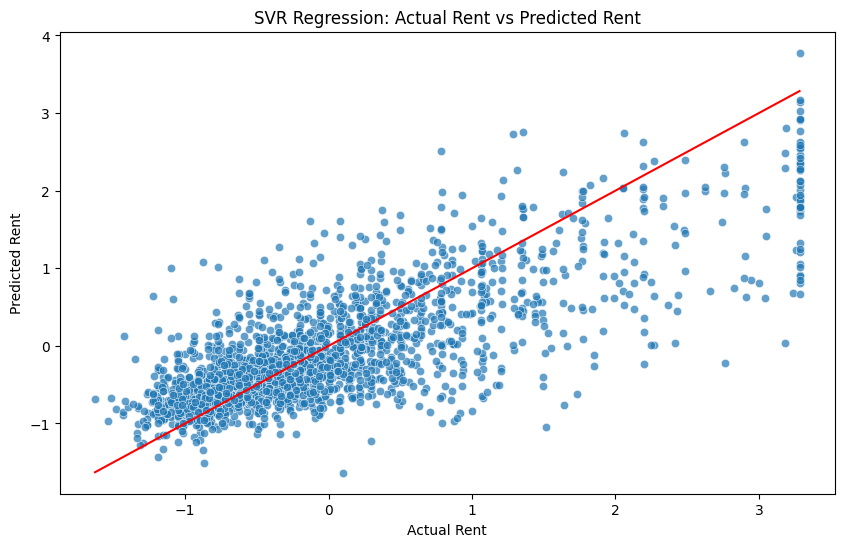

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Prepare features and target
X = rent_apartments_dataset.drop(columns=['price'])
y = rent_apartments_dataset['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the best parameters for SVR
best_params_svr = {
    'C': 10,
    'epsilon': 0.2,
    'kernel': 'rbf'
}

# Initialize the SVR with the best parameters
best_svr = SVR(C=best_params_svr['C'], epsilon=best_params_svr['epsilon'], kernel=best_params_svr['kernel'])

# Perform cross-validation
cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores_svr = cross_val_score(best_svr, X_train_scaled, y_train, cv=cv, scoring='neg_mean_squared_error')

# Train the model using the training data
best_svr.fit(X_train_scaled, y_train)

# Make predictions on the testing data
y_pred_svr = best_svr.predict(X_test_scaled)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred_svr)
mae = mean_absolute_error(y_test, y_pred_svr)
r2 = r2_score(y_test, y_pred_svr)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Save the evaluation metrics and results in a dictionary
results_svr = {
    'Model': 'SVR',
    'Cross-Validation MSE': -cv_scores_svr,
    'Mean Cross-Validation MSE': -np.mean(cv_scores_svr),
    'Test MSE': mse,
    'R²': r2,
    'MAE': mae,
    'Predictions': y_pred_svr
}

rent_results_df = pd.DataFrame([results_svr])


# Plotting Actual vs Predicted Rent
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_svr, alpha=0.7)
sns.lineplot(x=[min(y_test), max(y_test)], y=[min(y_test), max(y_test)], color='red')
plt.xlabel("Actual Rent")
plt.ylabel("Predicted Rent")
plt.title("SVR Regression: Actual Rent vs Predicted Rent")
plt.show()

In [ ]:
rent_results_df = pd.DataFrame([results_svr])

KNN

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [112]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from collections import deque
import random
from skopt import gp_minimize
from skopt.space import Real, Integer

target_column = 'price'


X = rent_apartments_dataset.drop(columns=[target_column])
y = rent_apartments_dataset[target_column]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Custom Neural Network Class
class CustomDQN(nn.Module):
    def __init__(self, input_dim, dropout_rate):
        super(CustomDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 50)
        self.fc2 = nn.Linear(50, 100)
        self.fc3 = nn.Linear(100, 50)
        self.fc4 = nn.Linear(50, 1)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.tanh(self.fc1(x))
        x = self.dropout(self.tanh(self.fc2(x)))
        x = self.tanh(self.fc3(x))
        x = self.fc4(x)
        return x

# DQN Agent Class
class DQNAgent:
    def __init__(self, state_dim, learning_rate, gamma, epsilon, epsilon_decay, epsilon_min, memory_size, batch_size, dropout_rate):
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.model = CustomDQN(state_dim, dropout_rate)
        self.target_model = CustomDQN(state_dim, dropout_rate)
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=10, gamma=0.95)
        self.criterion = nn.MSELoss()
        self.update_target_network()

    def update_target_network(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, reward, next_state, done):
        self.memory.append((state, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.random.rand()
        state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            return self.model(state).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        minibatch = random.sample(self.memory, self.batch_size)
        states, rewards, next_states, dones = zip(*minibatch)
        states, rewards, next_states, dones = map(torch.tensor, (states, rewards, next_states, dones))

        # Convert dones to float tensor
        dones = dones.float()

        q_values = self.model(states)
        next_q_values = self.target_model(next_states).detach()
        target_q_values = rewards.view(-1, 1) + self.gamma * next_q_values * (1 - dones.view(-1, 1))

        loss = self.criterion(q_values, target_q_values)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.scheduler.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

# Training Function
def train_dqn_agent(agent, X_train, y_train, n_episodes, target_update_freq, min_memory_size):
    loss_history = []
    for episode in range(n_episodes):
        for idx in range(len(X_train)):
            state = X_train[idx].numpy()
            reward = y_train[idx].item()
            next_state = state
            done = True
            agent.remember(state, reward, next_state, done)
            if len(agent.memory) >= min_memory_size:
                loss = agent.replay()

        if episode % target_update_freq == 0:
            agent.update_target_network()
        print(f"Episode {episode + 1}/{n_episodes} completed.")
        if len(agent.memory) >= min_memory_size:
            loss_history.append(loss)
    return loss_history

# Evaluation Function
def evaluate_dqn_agent(agent, X_test, y_test):
    agent.model.eval()
    y_pred = [agent.act(X_test[idx].unsqueeze(0).numpy()) for idx in range(len(X_test))]
    y_pred = np.array(y_pred).reshape(-1, 1)
    mse = mean_squared_error(y_test.numpy(), y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test.numpy(), y_pred)
    print(f"Evaluation MSE: {mse:.4f}")
    print(f"Evaluation RMSE: {rmse:.4f}")
    print(f"Evaluation MAE: {mae:.4f}")
    agent.model.train()
    return mse, rmse, mae, y_pred

# Best hyperparameters from Bayesian Optimization
best_learning_rate = 0.006835044632019021
best_batch_size = 133
best_dropout_rate = 0.10530598446394662
best_gamma = 0.9932779738128005
best_epsilon_decay = 0.9956205179412967
best_target_update_freq = 11

# Initialize the DQN agent with the best hyperparameters
best_agent = DQNAgent(
    state_dim=X_train.shape[1],
    learning_rate=best_learning_rate,
    gamma=best_gamma,
    epsilon=1.0,
    epsilon_decay=best_epsilon_decay,
    epsilon_min=0.01,
    memory_size=5000,
    batch_size=best_batch_size,
    dropout_rate=best_dropout_rate
)

# Train the agent
n_episodes = 20
train_dqn_agent(best_agent, X_train, y_train, n_episodes=n_episodes, target_update_freq=best_target_update_freq, min_memory_size=1000)

# Evaluate the agent
mse, rmse, mae, y_pred = evaluate_dqn_agent(best_agent, X_test, y_test)

# Save results to a dictionary
results_dqn = {
    'Model': 'DQN Regressor',
    'Test MSE': mse,
    'Test RMSE': rmse,
    'Test MAE': mae,
    'Predictions': y_pred
}

print(results_dqn)

Episode 1/20 completed.
Episode 2/20 completed.
Episode 3/20 completed.
Episode 4/20 completed.
Episode 5/20 completed.
Episode 6/20 completed.
Episode 7/20 completed.
Episode 8/20 completed.
Episode 9/20 completed.
Episode 10/20 completed.
Episode 11/20 completed.
Episode 12/20 completed.
Episode 13/20 completed.
Episode 14/20 completed.
Episode 15/20 completed.
Episode 16/20 completed.
Episode 17/20 completed.
Episode 18/20 completed.
Episode 19/20 completed.
Episode 20/20 completed.
Evaluation MSE: 0.4707
Evaluation RMSE: 0.6861
Evaluation MAE: 0.5003
{'Model': 'DQN Regressor', 'Test MSE': 0.47072441383883995, 'Test RMSE': 0.6860935897083137, 'Test MAE': 0.5003245419423777, 'Predictions': array([[ 0.92377698],
       [-0.44845942],
       [-0.23848525],
       ...,
       [-0.66206539],
       [ 0.17556122],
       [-0.99130166]])}


rent dataset algorithm comparison

In [113]:
rent_results_list = [results_dqn, results_svr, results_mlp, results_xgb, results_tree]

# Convert the list of dictionaries to a DataFrame
metrics_df = pd.DataFrame(rent_results_list)

# Set 'Model' column as the index
metrics_df.set_index('Model', inplace=True)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for idx, col in enumerate(comparison_df.columns[1:]):
    sns.scatterplot(x='Actual', y=col, data=comparison_df, alpha=0.7, ax=axes[idx])
    sns.lineplot(x=[comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                 y=[comparison_df['Actual'].min(), comparison_df['Actual'].max()],
                 color='red', ax=axes[idx])
    axes[idx].set_title(f"Actual vs {col}")

# Hide any unused subplots (in case we don't have exactly 6 models)
for i in range(len(comparison_df.columns[1:]), len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


ValueError: Per-column arrays must each be 1-dimensional

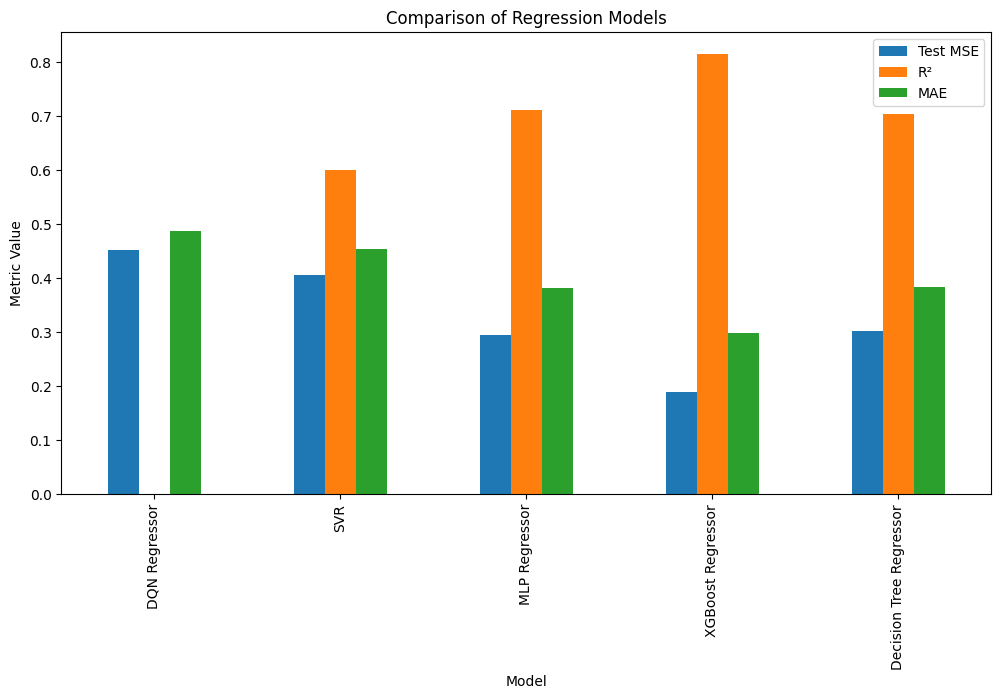

In [ ]:
# Plot the comparison of evaluation metrics
rent_results_list = [results_dqn, results_svr, results_mlp, results_xgb, results_tree]
metrics_df = pd.DataFrame(rent_results_list)


metrics_df = metrics_df.set_index('Model')[['Test MSE', 'R²', 'MAE']]
metrics_df.plot(kind='bar', figsize=(12, 6))
plt.title('Comparison of Regression Models')
plt.ylabel('Metric Value')
plt.xlabel('Model')
plt.show()

In [ ]:
for result_dict in rent_results_list:
    for key, value in result_dict.items():
        print(f"{key}: {value}")
    print()

Model: DQN Regressor
Cross-Validation MSE: nan
Mean Cross-Validation MSE: nan
Test MSE: 0.4526434973499194
R²: nan
MAE: 0.48759113298454526
Predictions: [ 0.67642772 -0.44985971 -0.23316506 ... -0.62090242  0.03371966
 -0.8024323 ]

Model: SVR
Cross-Validation MSE: [0.390275   0.43096292 0.43684321 0.42741259 0.44845454]
Mean Cross-Validation MSE: 0.42678965122855655
Test MSE: 0.4062137474134498
R²: 0.6007864473664428
MAE: 0.4539914490984055
Predictions: [ 0.92415198 -0.46204459 -0.15313972 ... -0.99804818  0.61779657
 -1.42974794]

Model: MLP Regressor
Cross-Validation MSE: [0.2981734  0.32535067 0.35004429 0.33127187 0.35794774]
Mean Cross-Validation MSE: 0.3325575958929049
Test MSE: 0.29462590881751327
R²: 0.7104513165645866
MAE: 0.3813425598152561
Predictions: [ 0.37301466 -0.41485457 -0.24751323 ... -0.91918542  0.85579403
 -1.17591743]

Model: XGBoost Regressor
Cross-Validation MSE: [0.18458045 0.20029029 0.20406576 0.22428847 0.22929171]
Mean Cross-Validation MSE: 0.208503336687